#### Assignment 1: An Experimental Study on Treaps


Key components:

1) Data Generator

2) Randomized Treap

3) Competitior

In [1]:
import random
import time
import numpy as np
import matplotlib.pyplot as plt
from graphviz import Digraph, Source

### Task 1: Implementations

In [2]:
class DataGenerator():
    def __init__(self):
        self.data = []
        self.id_next = 1

    def gen_element(self):
       # sample a uniform random integer key from [0, 10^7]
       key = random.randint(0, 10**7)
       id = self.id_next
       self.id_next += 1
       self.data.append(key)
       return (id, key)
    
    def gen_insertion(self):
        x = self.gen_element()
        return (1, x)
    
    def gen_deletion(self):
        # sample a uniform random integer id from [1, id_next-1]
        id_del = random.randint(1, self.id_next-1)
        # get the key associated with id_del
        key_del = self.data[id_del-1]
        return (2, key_del)

    def gen_search(self):
      # sample a uniform random integer key from [0, 10^7]
       key_sch = random.randint(0, 10**7)
       return (3, key_sch)  


In [45]:
class Node:
    def __init__(self, id, key, priority, parent=None):
        self.id = id
        self.key = key
        self.priority = priority
        self.parent = parent
        self.left = None
        self.right = None
        
class Treap:
    def __init__(self, root=None): 
        self.root = root
        self.size = 0

    def compute_height(self):
        # perform BFS to compute the height of the tree
        if self.root is None:
            return 0
        else:
            height = 0
            queue = [self.root]
            while len(queue) > 0:
                level = []
                for node in queue:
                    if node.left is not None:
                        level.append(node.left)
                    if node.right is not None:
                        level.append(node.right)
                queue = level
                height += 1
            return height
    
    def perform_operation(self, op, x):
        if op == 1:
            self.insert(x)
        elif op == 2:
            self.delete(x)
        elif op == 3:
            return self.search(x)
        else:
            print("Invalid operation!")


    def insert(self, x, custom_priority=None):
        id, key = x
        # generate uniform random priority from [0,1]
        if custom_priority is None:
            priority = random.uniform(0,1)
        else:
            priority = custom_priority    
        #print(f"Inserting key: {key} with priority: {priority}")
        
        if self.root is None:
            self.root = Node(id, key, priority)
        else:
            # use binary search to find the correct position for the new node
            current = self.root
            while True:
                #print(f"current: {current.key}, children: {current.left.key if current.left else None}, {current.right.key if current.right else None}")
                if key < current.key: # left subtree contains all keys less than the current node's key
                    if current.left is None:
                        new_node = Node(id, key, priority, parent=current)
                        current.left = new_node
                        break
                    current = current.left
                elif key > current.key: # right subtree contains all keys greater than the current node's key
                    if current.right is None:
                        new_node = Node(id, key, priority, parent=current)
                        current.right = new_node
                        break
                    current = current.right
                else:
                    # if key already exists, then use id instead of key to break the tie
                    if id < current.id:
                        if current.left is None:
                            new_node = Node(id, key, priority, parent=current)
                            current.left = new_node
                            break
                        current = current.left    
                    else:
                        if current.right is None:
                            new_node = Node(id, key, priority, parent=current)
                            current.right = new_node
                            break
                        current = current.right    

            #visualize_tree(self.root)

            # fix heap property violation
            self.restore_heap_insert(new_node)

        self.size += 1    


    def delete(self, key_del):
        # perform binary search to find the node with the given key
        current = self.root
        while current is not None:
            if key_del == current.key:
                current.priority = float('inf') # not necessary since we have a separate function for restoring heap property after a delete operation
                # fix heap property violation
                self.restore_heap_delete(current)   
                # remove the node from the tree
                parent = current.parent
                current.parent = None
                if parent is not None:
                    if parent.left == current:
                        parent.left = None
                    else:
                        parent.right = None

                self.size -= 1                          
                return 
            
            elif key_del < current.key:
                current = current.left
            else:
                current = current.right

        print(f"Key {key_del} not found!")
        return 
        
    
    def search(self, key_sch):
        # perform binary search to find the node with the given key
        current = self.root
        while current is not None:
            if key_sch == current.key:
                return current
            elif key_sch < current.key:
                current = current.left
            else:
                current = current.right
        return None   


    def restore_heap_insert(self, node):    
        #print(f"Node priority: {node.priority}, parent priority: {node.parent.priority if node.parent else None}")
        # check for min-heap property violation
        while node != self.root and (node.priority < node.parent.priority):
            #print(f"Node {node.key} violates heap property")
            if node == node.parent.left:
                # node is a left child, perform right rotation
                #print(f"Performing right rotation on node {node.key}")
                self.rotate_right(node)
            else:
                # node is a right child, perform left rotation
                #print(f"Performing left rotation on node {node.key}")
                self.rotate_left(node)
            #visualize_tree(self.root)    


    def restore_heap_delete(self, node):    
        #print(f"Node priority: {node.priority}, parent priority: {node.parent.priority if node.parent else None}")
        # perform rotations to bring node down to leaf level
        while node.left is not None or node.right is not None:
            if node.left is None:
                # perform left rotation on right child if node only has a right child
                #print(f"Performing left rotation on node {node.key}")
                self.rotate_left(node.right)
            elif node.right is None:
                # perform right rotation on left child if node only has a left child 
                #print(f"Performing right rotation on node {node.key}")
                self.rotate_right(node.left)
            else:
                # find child with the smaller priority
                if node.left.priority < node.right.priority:
                    # perform right rotation on left child which has smaller priority
                    #print(f"Performing right rotation on node {node.left.key}")
                    self.rotate_right(node.left)
                else:
                    # perform left rotation on right child which has smaller priority
                    #print(f"Performing left rotation on node {node.right.key}")
                    self.rotate_left(node.right)            


    def rotate_right(self, x):
        """
        Initially:    
             y
            /  \
           x    C
          / \ 
         A   B

        After right rotation on node x:
                x
              /   \
             A     y
                  / \ 
                 B   C
        """
        y = x.parent # parent of x
        g = y.parent # grandparent of x
        B = x.right
        # perform right rotation
        x.right = y
        y.parent = x
        y.left = B
        if B is not None:
            B.parent = y
        x.parent = g
        if g is not None:
            if g.left == y:
                g.left = x
            else:
                g.right = x
        else:
            self.root = x    


    def rotate_left(self, x):
        """
        Intially:
                y
              /   \
             A     x
                  / \ 
                 B   C
 
        After left rotation on node x:       
             x
            /  \
           y    C
          / \ 
         A   B

        """
        y = x.parent # parent of x
        g = y.parent # grandparent of x
        B = x.left
        # perform right rotation
        x.left = y
        y.parent = x
        y.right = B
        if B is not None:
            B.parent = y
        x.parent = g
        if g is not None:
            if g.left == y:
                g.left = x
            else:
                g.right = x
        else:
            self.root = x               

def add_nodes_edges(graph, node, counter=0):
    if node is not None:
        root = str(counter)
        graph.node(root, f"{node.key}, {node.priority:.2f}")
        if node.left is not None:
            left = str(counter + 1)
            graph.edge(root, left)
            counter = add_nodes_edges(graph, node.left, counter + 1)
        else:
            # Add a dummy node if the node has no left child
            left = str(counter + 1)
            graph.node(left, "null")
            graph.edge(root, left)
            counter += 1
        if node.right is not None:
            right = str(counter + 1)
            graph.edge(root, right)
            counter = add_nodes_edges(graph, node.right, counter + 1)
        else:
            # Add a dummy node if the node has no right child
            right = str(counter + 1)
            graph.node(right, "null")
            graph.edge(root, right)
            counter += 1
    return counter

def visualize_tree(root):
    graph = Digraph()
    add_nodes_edges(graph, root)
    src = Source(graph.source)
    display(src)                   

In [46]:
class Competitor():
    def __init__(self):
        self.A = np.zeros(shape=(2,2), dtype=int) # N x 2 array
        self.n = 0 # current number of elements in the array
        self.N = 2 # current size of the array

    # dynamic array push-back operation
    def push_back(self, x):
        id, key = x
        self.A[self.n,0] = id
        self.A[self.n,1] = key
        self.n += 1
        
        # if the array is full, double its size
        if self.n == self.N:
            self.N *= 2 
            self.A_new = np.zeros(shape=(self.N,2), dtype=int)
            self.A_new[:self.n,:] = self.A
            self.A = self.A_new

    def perform_operation(self, op, x):
        if op == 1:
            self.insert(x)
        elif op == 2:
            self.delete(x)
        elif op == 3:
            return self.search(x)
        else:
            print("Invalid operation!")


    def insert(self, x):
        self.push_back(x)

    def delete(self, key_del):
        # scan the array from beginning to end to find the element with the given key
        for i in range(self.n):
            if key_del == self.A[i,1]:
                # swap the element with the last element in the array
                self.A[i,0] = self.A[self.n-1,0]
                self.A[i,1] = self.A[self.n-1,1]
                # delete the last element of the array
                self.n -= 1

        # shrink the array by half if the number of elements is less than N/4 
        if self.n < self.N // 4:
            self.N //= 2
            self.A_new = np.zeros(shape=(self.N,2), dtype=int)
            self.A_new[:self.n,:] = self.A[:self.n,:]
            self.A = self.A_new      

    def search(self, key_sch):
        # scan the array from beginning to end to find the element with the given key
        for i in range(self.n):
            if key_sch == self.A[i,1]:
                return (self.A[i,0], self.A[i,1])
        return None          
                

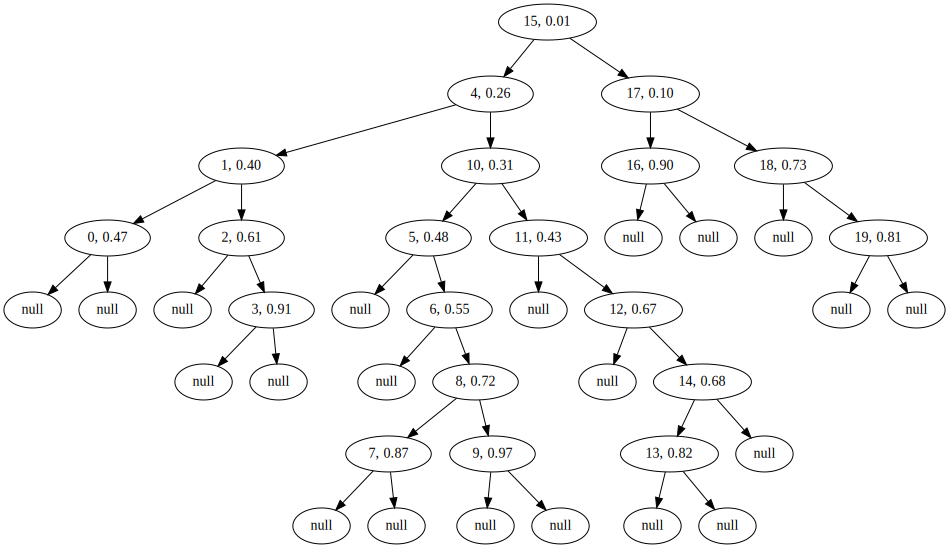

Key 11 not found!


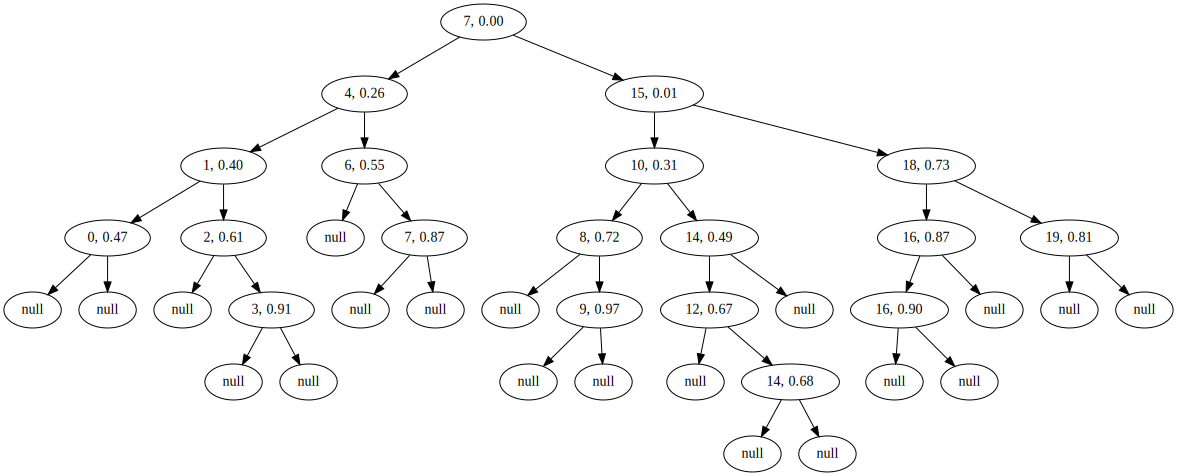

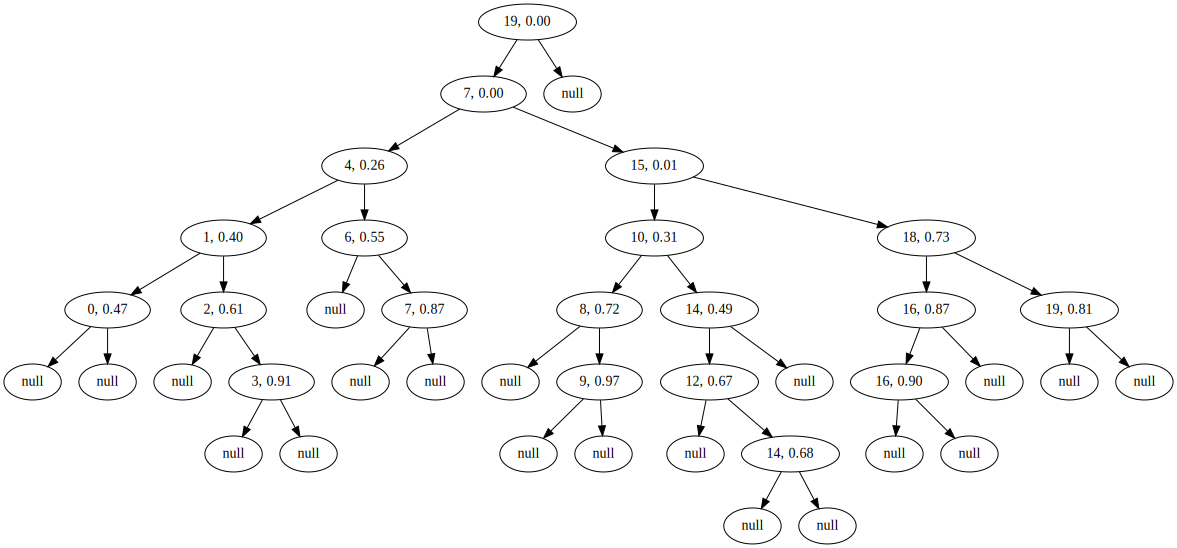

{'id': 1, 'key': 18, 'priority': 0.7298317482601286, 'parent': <__main__.Node object at 0x7f07d3dfcf90>, 'left': <__main__.Node object at 0x7f081c385550>, 'right': <__main__.Node object at 0x7f07d3dfc650>}


In [48]:

# test the treap implementation
random.seed(0)
treap = Treap()
N = 20
keys = list(range(N))
random.shuffle(keys)

for id, key in enumerate(keys):
    treap.insert((id, key))

# visualize the tree
src = visualize_tree(treap.root)

# perform some deletes and inserts
treap.delete(17)
treap.delete(13)
treap.insert((N, 7))
treap.delete(5)
treap.insert((N+1, 14))
treap.insert((N+2, 16))
treap.delete(11)
treap.delete(11)
visualize_tree(treap.root)

treap.insert((N+3, 19), 0.0005)

visualize_tree(treap.root)

print(treap.search(18).__dict__)


### Task 2: Experiments

Running insertions... L = 100000.0
Running insertions... L = 200000.0
Running insertions... L = 500000.0
Running insertions... L = 800000.0
Running insertions... L = 1000000.0


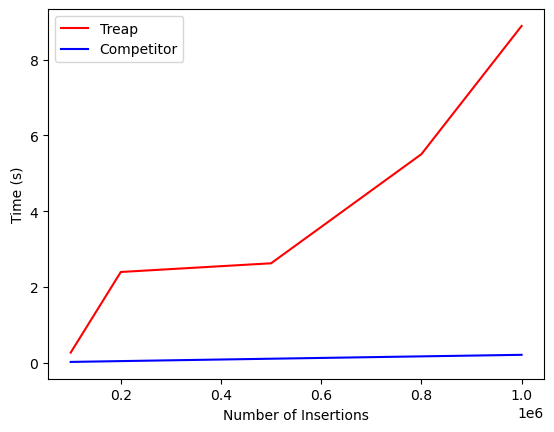

In [49]:
# Experiment 1: Time vs Number of Insertions

L_ins = [0.1e6, 0.2e6, 0.5e6, 0.8e6, 1e6]
treap_times = []
competitor_times = []

for L in L_ins:

    print(f"Running insertions... L = {L}")

    # initialize data generator
    data_gen = DataGenerator()
    # initialize treap
    treap = Treap()
    # initialize competitor
    competitor = Competitor()
    # generate insertion sequence
    sigma = []
    for i in range(int(L)):
        sigma.append(data_gen.gen_insertion())

    # perform insertions on treap and time the sequence
    t1 = time.time()    
    for op, x in sigma:
        treap.perform_operation(op, x)
    t2 = time.time()
    treap_times.append(t2-t1)

    # perform insertions on competitor and time the sequence
    t1 = time.time()
    for op, x in sigma:
        competitor.perform_operation(op, x)
    t2 = time.time()
    competitor_times.append(t2-t1)       

# plot time vs number of insertions
plt.plot(L_ins, treap_times, label='Treap', color='r')
plt.plot(L_ins, competitor_times, label='Competitor', color='b')
plt.xlabel('Number of Insertions')
plt.ylabel('Time (s)')
plt.legend()


### Need to experimentally determine the constant factors infront of the treap expected log(n) times. Supposed to be large according to tutor. Wnat to experimentally verify this....

Running operations... percent_del = 0.1
Treap done.
Competitor done.
Running operations... percent_del = 0.5
Treap done.
Competitor done.
Running operations... percent_del = 1
Treap done.
Competitor done.
Running operations... percent_del = 5
Treap done.
Competitor done.
Running operations... percent_del = 10
Treap done.
Competitor done.


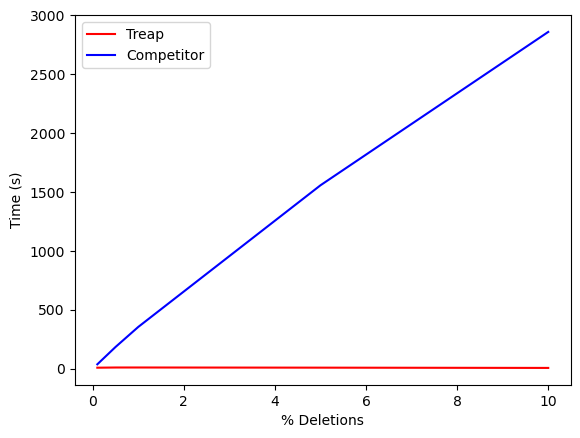

In [5]:
# Experiment 2: Time vs Deletion Percentage

L = 1e6
percent_del = [0.1, 0.5, 1, 5, 10]
treap_times = []
competitor_times = []

for pdel in percent_del:

    print(f"Running operations... % del = {pdel}")

    # initialize data generator
    data_gen = DataGenerator()
    # initialize treap
    treap = Treap()
    # initialize competitor
    competitor = Competitor()
    # generate operation sequence
    sigma = []
    for i in range(int(L)):
        # generate uniform random number from [0,1]
        r = random.random()
        if r < pdel/100:
            sigma.append(data_gen.gen_deletion())
        else:    
            sigma.append(data_gen.gen_insertion())

    # perform operations on treap and time the sequence
    t1 = time.time()    
    for op, x in sigma:
        treap.perform_operation(op, x)
    t2 = time.time()
    treap_times.append(t2-t1)
    print(f"Treap done.")

    # perform operations on competitor and time the sequence
    t1 = time.time()
    for op, x in sigma:
        competitor.perform_operation(op, x)
    t2 = time.time()
    competitor_times.append(t2-t1)   
    print(f"Competitor done.")    

# plot time vs number of insertions
plt.plot(percent_del, treap_times, label='Treap', color='r')
plt.plot(percent_del, competitor_times, label='Competitor', color='b')
plt.xlabel('% Deletions')
plt.ylabel('Time (s)')
plt.legend()


Running operations... % search = 0.1
Treap done.
Competitor done.
Running operations... % search = 0.5
Treap done.
Competitor done.
Running operations... % search = 1
Treap done.
Competitor done.
Running operations... % search = 5
Treap done.
Competitor done.
Running operations... % search = 10
Treap done.
Competitor done.


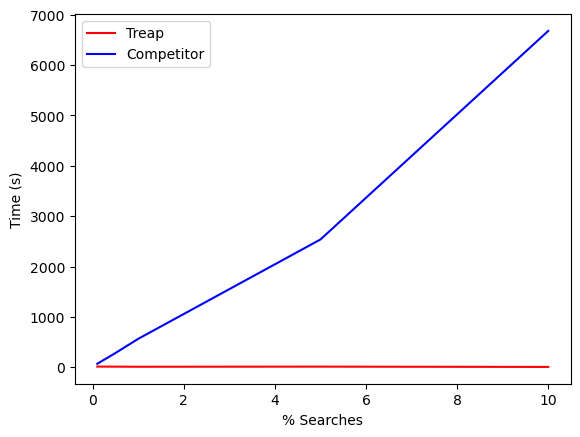

In [6]:
# Experiment 3: Time vs Search Percentage

L = 1e6
percent_sch = [0.1, 0.5, 1, 5, 10]
treap_times = []
competitor_times = []

for psch in percent_sch:

    print(f"Running operations... % search = {psch}")

    # initialize data generator
    data_gen = DataGenerator()
    # initialize treap
    treap = Treap()
    # initialize competitor
    competitor = Competitor()
    # generate operation sequence
    sigma = []
    for i in range(int(L)):
        # generate uniform random number from [0,1]
        r = random.random()
        if r < psch/100:
            sigma.append(data_gen.gen_search())
        else:    
            sigma.append(data_gen.gen_insertion())

    # perform operations on treap and time the sequence
    t1 = time.time()    
    for op, x in sigma:
        treap.perform_operation(op, x)
    t2 = time.time()
    treap_times.append(t2-t1)
    print(f"Treap done.")

    # perform operations on competitor and time the sequence
    t1 = time.time()
    for op, x in sigma:
        competitor.perform_operation(op, x)
    t2 = time.time()
    competitor_times.append(t2-t1)   
    print(f"Competitor done.")    

# plot time vs number of insertions
plt.plot(percent_sch, treap_times, label='Treap', color='r')
plt.plot(percent_sch, competitor_times, label='Competitor', color='b')
plt.xlabel('% Searches')
plt.ylabel('Time (s)')
plt.legend()
